In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Processed_Purchase_and_Return_Data.csv to Processed_Purchase_and_Return_Data.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from collections import defaultdict


In [ ]:
# Load the synthesized dataset
data = pd.read_csv('Processed_Purchase_and_Return_Data.csv')

In [ ]:
# Define a function to simulate a more realistic size change after a return
def simulate_realistic_size_change(row):
    if row['Returned']:
        sizes = ['S', 'M', 'L', 'XL']
        current_size = row['Estimated Size']
        current_index = sizes.index(current_size)
        # Randomly choose to go up or down a size, ensuring it's different
        if current_index > 0 and current_index < len(sizes) - 1:
            new_index = np.random.choice([current_index - 1, current_index + 1])
        elif current_index == 0:
            new_index = current_index + 1
        elif current_index == len(sizes) - 1:
            new_index = current_index - 1
        return sizes[new_index]
    else:
        return row['Estimated Size']  # No change if not returned

# Apply the function to the dataset
data['New Size After Return'] = data.apply(simulate_realistic_size_change, axis=1)

# Display the updated dataset
data.head()


,Gender,Height,Weight,Bust/Chest,Cup Size,Waist,Hips,Body Shape Index,Height (inches),Estimated Size,Returned,New Size After Return,SizeType,NewSizeType
0,Female,"5'1""",67,37,E,35,38,4,61,XL,False,XL,XL,XL
1,Male,"6'1""",85,40,NaN,30,31,3,73,M,False,M,M,M
2,Male,"5'3""",77,44,NaN,36,42,4,63,L,False,L,L,L
3,Male,"6'4""",74,38,NaN,48,49,4,76,XL,False,XL,XL,XL
4,Male,"4'11""",47,35,NaN,39,41,0,59,L,True,M,L,XL


In [ ]:
data

,Gender,Height,Weight,Bust/Chest,Cup Size,Waist,Hips,Body Shape Index,Height (inches),Estimated Size,Returned,New Size After Return,SizeType,NewSizeType
0,Female,"5'1""",67,37,E,35,38,4,61,XL,False,XL,XL,XL
1,Male,"6'1""",85,40,NaN,30,31,3,73,M,False,M,M,M
2,Male,"5'3""",77,44,NaN,36,42,4,63,L,False,L,L,L
3,Male,"6'4""",74,38,NaN,48,49,4,76,XL,False,XL,XL,XL
4,Male,"4'11""",47,35,NaN,39,41,0,59,L,True,M,L,XL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Female,"5'2""",70,40,DD,34,36,3,62,XL,True,L,XL,XL
996,Female,"5'6""",84,47,F,36,38,0,66,XL,False,XL,XL,XL
997,Male,"6'4""",73,47,NaN,31,38,2,76,XL,True,L,XL,XL
998,Female,"5'1""",45,34,E,25,29,1,61,S,False,S,S,S


In [ ]:
# Step 1: Organize Sizes into Types
def identify_size_type(size):
    if size in ['XS', 'S', 'Small']:
        return 'S'
    elif size in ['M', 'Medium']:
        return 'M'
    elif size in ['L', 'Large']:
        return 'L'
    elif size in ['XL', 'Extra Large']:
        return 'XL'
    return 'Unknown'

In [ ]:
# Apply size type identification
data['SizeType'] = data['Estimated Size'].apply(identify_size_type)
data['NewSizeType'] = data['New Size After Return'].apply(identify_size_type)


In [ ]:
# Step 2: Create a Frequency Matrix
frequency_matrix = pd.crosstab(data['SizeType'], data['NewSizeType'], normalize=False)


In [ ]:
frequency_matrix

NewSizeType,L,M,S,XL
SizeType,,,,
L,152,36,0,31
M,16,102,25,0
S,0,31,83,0
XL,91,0,0,433


In [ ]:
# Step 3: Assign Normalized Size Values
size_positions = {'S': 1.0, 'M': 2.0, 'L': 3.0, 'XL': 4.0}


In [ ]:
# Step 4: Size Inference and Optimization
# Minimize Differences Between Sizes
def objective_function(positions):
    loss = 0
    size_list = list(size_positions.keys())
    for i, size1 in enumerate(size_list):
        for j, size2 in enumerate(size_list):
            if i != j:
                distance = abs(positions[i] - positions[j])
                frequency = frequency_matrix.at[size1, size2]
                loss += frequency * (distance ** 2)
    return loss

# Use scipy's minimize function to solve the QP problem
result = minimize(objective_function, np.array(list(size_positions.values())), method='SLSQP')
optimized_positions = dict(zip(size_positions.keys(), result.x))


In [ ]:
# Apply Gradient Descent with Hinge Loss
def gradient_descent(size_positions, learning_rate=0.01, epochs=1000):
    positions = size_positions.copy()  # Create a copy to avoid modifying the original
    for epoch in range(epochs):
        gradients = {size: 0 for size in positions}
        for size in positions:
            for other_size in positions:
                if size != other_size:
                    difference = positions[size] - positions[other_size]
                    hinge_loss = max(0, 0.1 - abs(difference))
                    gradients[size] += hinge_loss
        for size in positions:
            positions[size] -= learning_rate * gradients[size]
    return positions

# Run Gradient Descent
gd_positions = gradient_descent(size_positions)


In [ ]:
# Combine QP and GD results
final_size_scale = {size: (optimized_positions[size] + gd_positions[size]) / 2 for size in size_positions}


In [ ]:
final_size_scale

{'S': 1.7499999896863627,
 'M': 2.2499999888533377,
 'L': 2.7499999901298215,
 'XL': 3.24999998860823}

In [ ]:
# Function to calculate the best size recommendation based on stability
def recommend_stable_size(frequency_matrix):
    recommendations = {}
    for size in frequency_matrix.index:
        # Calculate the percentage of times the size was kept (no change)
        kept_percentage = frequency_matrix.at[size, size] / frequency_matrix.loc[size].sum()
        recommendations[size] = kept_percentage
    # Sort the recommendations by stability
    sorted_recommendations = sorted(recommendations.items(), key=lambda item: item[1], reverse=True)
    return sorted_recommendations


In [ ]:
# Separate the data by gender
male_data = data[data['Gender'] == 'Male']
female_data = data[data['Gender'] == 'Female']

# Create frequency matrices for male and female data
male_frequency_matrix = pd.crosstab(male_data['SizeType'], male_data['NewSizeType'], normalize=False)
female_frequency_matrix = pd.crosstab(female_data['SizeType'], female_data['NewSizeType'], normalize=False)

# Get the best size recommendations for each gender
male_recommendations = recommend_stable_size(male_frequency_matrix)
female_recommendations = recommend_stable_size(female_frequency_matrix)


In [ ]:
# Calculate the mean measurements for each size type
def calculate_mean_measurements(data, size_type):
    filtered_data = data[(data['SizeType'] == size_type) & (data['SizeType'] == data['NewSizeType'])]
    mean_bust = filtered_data['Bust/Chest'].mean()
    mean_waist = filtered_data['Waist'].mean()
    mean_hips = filtered_data['Hips'].mean()
    return mean_bust, mean_waist, mean_hips


In [ ]:
# Create a chart of recommended size measurements for each size type
def generate_size_recommendation_chart(data):
    sizes = ['S', 'M', 'L', 'XL']
    size_chart = pd.DataFrame(columns=['Size', 'Recommended Bust/Chest', 'Recommended Waist', 'Recommended Hips'])

    for size in sizes:
        mean_bust, mean_waist, mean_hips = calculate_mean_measurements(data, size)
        size_chart = pd.concat([size_chart, pd.DataFrame({
            'Size': [size],
            'Recommended Bust/Chest': [round(mean_bust, 2)],
            'Recommended Waist': [round(mean_waist, 2)],
            'Recommended Hips': [round(mean_hips, 2)]
        })])

    return size_chart

In [ ]:
# Generate the size recommendation chart for male and female customers
male_size_chart = generate_size_recommendation_chart(male_data)
female_size_chart = generate_size_recommendation_chart(female_data)


<ipython-input-17-bbbc8e1ae414>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  size_chart = pd.concat([size_chart, pd.DataFrame({
<ipython-input-17-bbbc8e1ae414>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  size_chart = pd.concat([size_chart, pd.DataFrame({


In [ ]:
pip install tabulate


In [ ]:
from tabulate import tabulate

def display_size_recommendation_table(size_chart, gender):
    print(f"{gender} Size Recommendations:")
    print(tabulate(size_chart, headers='keys', tablefmt='grid', showindex=False))
    print("\n")


In [ ]:
display_size_recommendation_table(male_size_chart, 'Male')
display_size_recommendation_table(female_size_chart, 'Female')

Male Size Recommendations:
+--------+--------------------------+---------------------+--------------------+
| Size   |   Recommended Bust/Chest |   Recommended Waist |   Recommended Hips |
+========+==========================+=====================+====================+
| S      |                    33.58 |               29.22 |              33.96 |
+--------+--------------------------+---------------------+--------------------+
| M      |                    38.17 |               32.55 |              38.15 |
+--------+--------------------------+---------------------+--------------------+
| L      |                    40.15 |               36.65 |              41.53 |
+--------+--------------------------+---------------------+--------------------+
| XL     |                    43.16 |               40.32 |              43.95 |
+--------+--------------------------+---------------------+--------------------+


Female Size Recommendations:
+--------+--------------------------+--------------

In [ ]:
def plot_size_recommendations(size_chart, gender):
    fig, ax = plt.subplots(figsize=(10, 6))
    index = np.arange(len(size_chart['Size']))
    bar_width = 0.2

    ax.bar(index, size_chart['Recommended Bust/Chest'], bar_width, label='Bust/Chest')
    ax.bar(index + bar_width, size_chart['Recommended Waist'], bar_width, label='Waist')
    ax.bar(index + 2 * bar_width, size_chart['Recommended Hips'], bar_width, label='Hips')

    ax.set_xlabel('Size')
    ax.set_ylabel('Measurement (inches)')
    ax.set_title(f'{gender} Size Recommendations')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(size_chart['Size'])
    ax.legend()

    plt.tight_layout()
    plt.show()


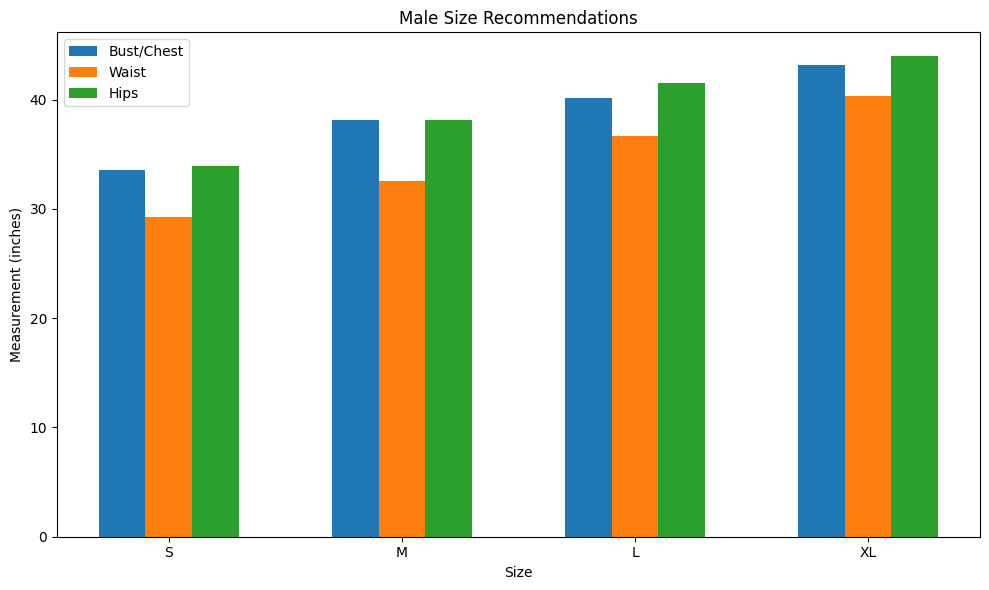

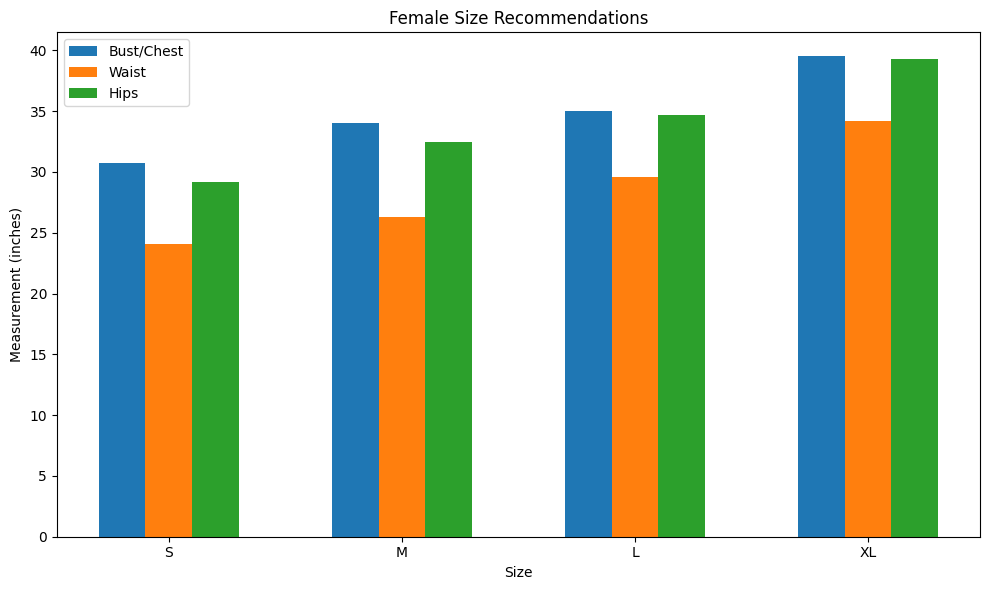

In [ ]:
plot_size_recommendations(male_size_chart, 'Male')
plot_size_recommendations(female_size_chart, 'Female')

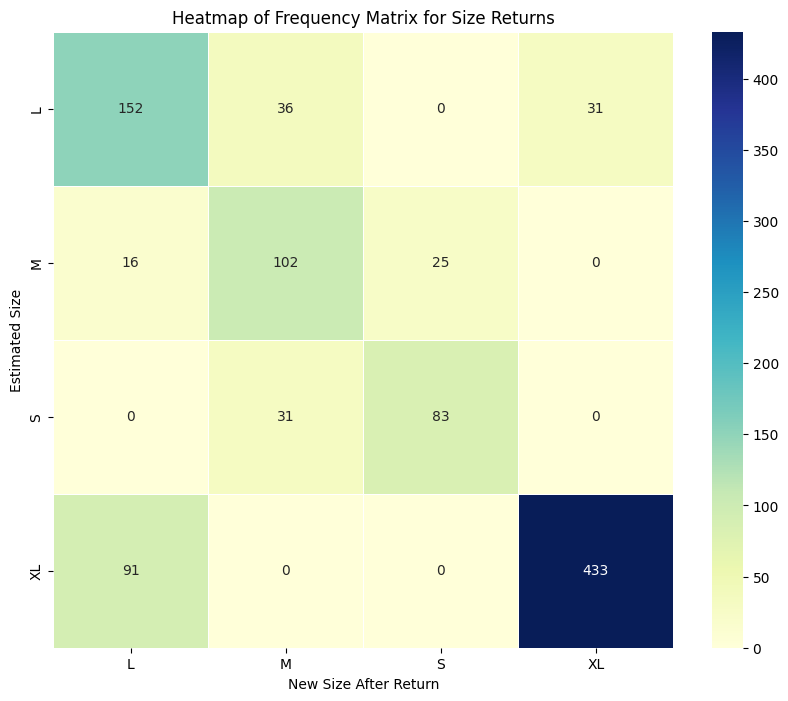

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the frequency matrix
plt.figure(figsize=(10, 8))
sns.heatmap(frequency_matrix, annot=True, cmap="YlGnBu", fmt="d", linewidths=.5)
plt.title('Heatmap of Frequency Matrix for Size Returns')
plt.xlabel('New Size After Return')
plt.ylabel('Estimated Size')
plt.show()